# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11613
EM converged at iteration 58, llf=-11376, convergence criterion=9.6625e-07 < tolerance=1e-06
EM start iterations, llf=-11625
EM converged at iteration 58, llf=-11388, convergence criterion=9.6531e-07 < tolerance=1e-06
EM start iterations, llf=-11675
EM converged at iteration 57, llf=-11435, convergence criterion=9.9929e-07 < tolerance=1e-06
EM start iterations, llf=-11682
EM converged at iteration 57, llf=-11442, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-11750
EM converged at iteration 59, llf=-11505, convergence criterion=9.8135e-07 < tolerance=1e-06
EM start iterations, llf=-11758
EM converged at iteration 59, llf=-11512, convergence criterion=9.7855e-07 < tolerance=1e-06
EM start iterations, llf=-11810
EM converged at iteration 59, llf=-11564, convergence criterion=9.8697e-07 < tolerance=1e-06
EM start iterations, llf=-11810
EM converged at iteration 59, llf=-11564, convergence criterion=9.8697e-07 < tolerance=1e-06


EM start iterations, llf=-13265
EM converged at iteration 48, llf=-13072, convergence criterion=9.6698e-07 < tolerance=1e-06
EM start iterations, llf=-13324
EM converged at iteration 46, llf=-13142, convergence criterion=9.9094e-07 < tolerance=1e-06
EM start iterations, llf=-13329
EM converged at iteration 46, llf=-13144, convergence criterion=9.8987e-07 < tolerance=1e-06
EM start iterations, llf=-13381
EM converged at iteration 46, llf=-13191, convergence criterion=9.8665e-07 < tolerance=1e-06
EM start iterations, llf=-13381
EM converged at iteration 46, llf=-13191, convergence criterion=9.8665e-07 < tolerance=1e-06
EM start iterations, llf=-13392
EM converged at iteration 46, llf=-13204, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-13441
EM converged at iteration 46, llf=-13255, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-13446
EM converged at iteration 46, llf=-13259, convergence criterion=9.9594e-07 < tolerance=1e-06


EM start iterations, llf=-14944
EM converged at iteration 47, llf=-14742, convergence criterion=9.9583e-07 < tolerance=1e-06
EM start iterations, llf=-14944
EM converged at iteration 47, llf=-14742, convergence criterion=9.9583e-07 < tolerance=1e-06
EM start iterations, llf=-14953
EM converged at iteration 47, llf=-14751, convergence criterion=9.9518e-07 < tolerance=1e-06
EM start iterations, llf=-15005
EM converged at iteration 47, llf=-14803, convergence criterion=9.9149e-07 < tolerance=1e-06
EM start iterations, llf=-15016
EM converged at iteration 47, llf=-14814, convergence criterion=9.8837e-07 < tolerance=1e-06
EM start iterations, llf=-15065
EM converged at iteration 47, llf=-14863, convergence criterion=9.9772e-07 < tolerance=1e-06
EM start iterations, llf=-15072
EM converged at iteration 47, llf=-14870, convergence criterion=9.9541e-07 < tolerance=1e-06
EM start iterations, llf=-15119
EM converged at iteration 47, llf=-14915, convergence criterion=9.9013e-07 < tolerance=1e-06


EM start iterations, llf=-16636
EM converged at iteration 56, llf=-16399, convergence criterion=9.7169e-07 < tolerance=1e-06
EM start iterations, llf=-16641
EM converged at iteration 56, llf=-16404, convergence criterion=9.7193e-07 < tolerance=1e-06
EM start iterations, llf=-16697
EM converged at iteration 56, llf=-16460, convergence criterion=9.7958e-07 < tolerance=1e-06
EM start iterations, llf=-16704
EM converged at iteration 56, llf=-16466, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-16758
EM converged at iteration 56, llf=-16521, convergence criterion=9.7556e-07 < tolerance=1e-06
EM start iterations, llf=-16758
EM converged at iteration 56, llf=-16521, convergence criterion=9.7556e-07 < tolerance=1e-06
EM start iterations, llf=-16767
EM converged at iteration 56, llf=-16531, convergence criterion=9.7365e-07 < tolerance=1e-06
EM start iterations, llf=-16817
EM converged at iteration 56, llf=-16581, convergence criterion=9.6953e-07 < tolerance=1e-06


EM start iterations, llf=-18138
EM converged at iteration 56, llf=-17888, convergence criterion=9.7547e-07 < tolerance=1e-06
EM start iterations, llf=-18195
EM converged at iteration 56, llf=-17944, convergence criterion=9.7184e-07 < tolerance=1e-06
EM start iterations, llf=-18195
EM converged at iteration 56, llf=-17944, convergence criterion=9.7184e-07 < tolerance=1e-06
EM start iterations, llf=-18200
EM converged at iteration 56, llf=-17949, convergence criterion=9.7176e-07 < tolerance=1e-06
EM start iterations, llf=-18251
EM converged at iteration 56, llf=-17998, convergence criterion=9.6943e-07 < tolerance=1e-06
EM start iterations, llf=-18258
EM converged at iteration 56, llf=-18006, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-18314
EM converged at iteration 56, llf=-18060, convergence criterion=9.7266e-07 < tolerance=1e-06
EM start iterations, llf=-18322
EM converged at iteration 56, llf=-18068, convergence criterion=9.725e-07 < tolerance=1e-06
E

EM start iterations, llf=-12167
EM converged at iteration 59, llf=-11904, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-12149
EM converged at iteration 59, llf=-11884, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-12211
EM converged at iteration 59, llf=-11959, convergence criterion=9.9081e-07 < tolerance=1e-06
EM start iterations, llf=-12230
EM converged at iteration 59, llf=-11984, convergence criterion=9.8576e-07 < tolerance=1e-06
EM start iterations, llf=-12284
EM converged at iteration 58, llf=-12056, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-12282
EM converged at iteration 58, llf=-12054, convergence criterion=9.8985e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 56, llf=-12049, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 56, llf=-12049, convergence criterion=9.892e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13784
EM converged at iteration 53, llf=-13585, convergence criterion=9.6962e-07 < tolerance=1e-06
EM start iterations, llf=-13817
EM converged at iteration 52, llf=-13611, convergence criterion=9.9243e-07 < tolerance=1e-06
EM start iterations, llf=-13823
EM converged at iteration 53, llf=-13623, convergence criterion=9.8391e-07 < tolerance=1e-06
EM start iterations, llf=-13871
EM converged at iteration 55, llf=-13679, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-13871
EM converged at iteration 55, llf=-13679, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-13881
EM converged at iteration 55, llf=-13690, convergence criterion=9.8076e-07 < tolerance=1e-06
EM start iterations, llf=-13933
EM converged at iteration 55, llf=-13740, convergence criterion=9.6821e-07 < tolerance=1e-06
EM start iterations, llf=-13940
EM converged at iteration 54, llf=-13747, convergence criterion=9.8915e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15494
EM converged at iteration 52, llf=-15278, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-15494
EM converged at iteration 52, llf=-15278, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-15502
EM converged at iteration 52, llf=-15286, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-15554
EM converged at iteration 52, llf=-15336, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-15557
EM converged at iteration 52, llf=-15338, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-15612
EM converged at iteration 53, llf=-15392, convergence criterion=9.6801e-07 < tolerance=1e-06
EM start iterations, llf=-15616
EM converged at iteration 53, llf=-15396, convergence criterion=9.6545e-07 < tolerance=1e-06
EM start iterations, llf=-15660
EM converged at iteration 53, llf=-15440, convergence criterion=9.6983e-07 < tolerance=1e-06


EM start iterations, llf=-17191
EM converged at iteration 60, llf=-16959, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-17197
EM converged at iteration 60, llf=-16964, convergence criterion=9.8193e-07 < tolerance=1e-06
EM start iterations, llf=-17248
EM converged at iteration 60, llf=-17015, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-17256
EM converged at iteration 60, llf=-17021, convergence criterion=9.8211e-07 < tolerance=1e-06
EM start iterations, llf=-17304
EM converged at iteration 60, llf=-17069, convergence criterion=9.7904e-07 < tolerance=1e-06
EM start iterations, llf=-17304
EM converged at iteration 60, llf=-17069, convergence criterion=9.7904e-07 < tolerance=1e-06
EM start iterations, llf=-17323
EM converged at iteration 60, llf=-17088, convergence criterion=9.7925e-07 < tolerance=1e-06
EM start iterations, llf=-17374
EM converged at iteration 60, llf=-17139, convergence criterion=9.7036e-07 < tolerance=1e-06


EM start iterations, llf=-18674
EM converged at iteration 59, llf=-18410, convergence criterion=9.9137e-07 < tolerance=1e-06
EM start iterations, llf=-18722
EM converged at iteration 59, llf=-18460, convergence criterion=9.8681e-07 < tolerance=1e-06
EM start iterations, llf=-18722
EM converged at iteration 59, llf=-18460, convergence criterion=9.8681e-07 < tolerance=1e-06
EM start iterations, llf=-18730
EM converged at iteration 59, llf=-18469, convergence criterion=9.8777e-07 < tolerance=1e-06
EM start iterations, llf=-18786
EM converged at iteration 59, llf=-18524, convergence criterion=9.8692e-07 < tolerance=1e-06
EM start iterations, llf=-18793
EM converged at iteration 59, llf=-18532, convergence criterion=9.8605e-07 < tolerance=1e-06
EM start iterations, llf=-18845
EM converged at iteration 58, llf=-18582, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-18854
EM converged at iteration 58, llf=-18590, convergence criterion=9.9802e-07 < tolerance=1e-06


EM start iterations, llf=-12561
EM converged at iteration 57, llf=-12353, convergence criterion=9.8511e-07 < tolerance=1e-06
EM start iterations, llf=-12567
EM converged at iteration 57, llf=-12360, convergence criterion=9.859e-07 < tolerance=1e-06
EM start iterations, llf=-12621
EM converged at iteration 57, llf=-12412, convergence criterion=9.7863e-07 < tolerance=1e-06
EM start iterations, llf=-12629
EM converged at iteration 57, llf=-12420, convergence criterion=9.79e-07 < tolerance=1e-06
EM start iterations, llf=-12675
EM converged at iteration 55, llf=-12460, convergence criterion=9.6003e-07 < tolerance=1e-06
EM start iterations, llf=-12686
EM converged at iteration 54, llf=-12470, convergence criterion=9.9328e-07 < tolerance=1e-06
EM start iterations, llf=-12746
EM converged at iteration 56, llf=-12538, convergence criterion=9.6422e-07 < tolerance=1e-06
EM start iterations, llf=-12746
EM converged at iteration 56, llf=-12538, convergence criterion=9.6422e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14272
EM converged at iteration 57, llf=-14082, convergence criterion=9.8767e-07 < tolerance=1e-06
EM start iterations, llf=-14331
EM converged at iteration 58, llf=-14145, convergence criterion=9.7576e-07 < tolerance=1e-06
EM start iterations, llf=-14339
EM converged at iteration 58, llf=-14150, convergence criterion=9.6242e-07 < tolerance=1e-06
EM start iterations, llf=-14392
EM converged at iteration 58, llf=-14206, convergence criterion=9.7411e-07 < tolerance=1e-06
EM start iterations, llf=-14392
EM converged at iteration 58, llf=-14206, convergence criterion=9.7411e-07 < tolerance=1e-06
EM start iterations, llf=-14400
EM converged at iteration 58, llf=-14212, convergence criterion=9.6458e-07 < tolerance=1e-06
EM start iterations, llf=-14454
EM converged at iteration 57, llf=-14265, convergence criterion=9.9554e-07 < tolerance=1e-06
EM start iterations, llf=-14462
EM converged at iteration 57, llf=-14272, convergence criterion=9.7771e-07 < tolerance=1e-06


EM start iterations, llf=-16017
EM converged at iteration 56, llf=-15806, convergence criterion=9.6126e-07 < tolerance=1e-06
EM start iterations, llf=-16017
EM converged at iteration 56, llf=-15806, convergence criterion=9.6126e-07 < tolerance=1e-06
EM start iterations, llf=-16026
EM converged at iteration 55, llf=-15814, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-16080
EM converged at iteration 55, llf=-15866, convergence criterion=9.9115e-07 < tolerance=1e-06
EM start iterations, llf=-16089
EM converged at iteration 55, llf=-15876, convergence criterion=9.8905e-07 < tolerance=1e-06
EM start iterations, llf=-16141
EM converged at iteration 55, llf=-15928, convergence criterion=9.8162e-07 < tolerance=1e-06
EM start iterations, llf=-16149
EM converged at iteration 55, llf=-15934, convergence criterion=9.7833e-07 < tolerance=1e-06
EM start iterations, llf=-16199
EM converged at iteration 55, llf=-15984, convergence criterion=9.7499e-07 < tolerance=1e-06


EM start iterations, llf=-17700
EM converged at iteration 61, llf=-17469, convergence criterion=9.8579e-07 < tolerance=1e-06
EM start iterations, llf=-17706
EM converged at iteration 61, llf=-17477, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-17759
EM converged at iteration 61, llf=-17527, convergence criterion=9.8413e-07 < tolerance=1e-06
EM start iterations, llf=-17766
EM converged at iteration 61, llf=-17535, convergence criterion=9.8369e-07 < tolerance=1e-06
EM start iterations, llf=-17822
EM converged at iteration 61, llf=-17589, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-17822
EM converged at iteration 61, llf=-17589, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-17826
EM converged at iteration 61, llf=-17592, convergence criterion=9.8055e-07 < tolerance=1e-06
EM start iterations, llf=-17876
EM converged at iteration 61, llf=-17641, convergence criterion=9.7691e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18911
EM converged at iteration 62, llf=-18653, convergence criterion=9.9025e-07 < tolerance=1e-06
EM start iterations, llf=-18964
EM converged at iteration 62, llf=-18707, convergence criterion=9.8927e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:10:36.379432.
EM start iterations, llf=-11138
EM converged at iteration 58, llf=-11001, convergence criterion=9.7882e-07 < tolerance=1e-06
EM start iterations, llf=-11151
EM converged at iteration 58, llf=-11014, convergence criterion=9.7598e-07 < tolerance=1e-06
EM start iterations, llf=-11199
EM converged at iteration 57, llf=-11062, convergence criterion=9.9814e-07 < tolerance=1e-06
EM start iterations, llf=-11207
EM converged at iteration 57, llf=-11070, convergence criterion=9.9617e-07 < tolerance=1e-06
EM start iterations, llf=-11267
EM converged at iteration 57, llf=-11132, convergence criterion=9.7622e-07 < tolerance=1e-06
EM start iterations, llf=-11278
EM converged at

EM start iterations, llf=-12552
EM converged at iteration 50, llf=-12406, convergence criterion=9.8809e-07 < tolerance=1e-06
EM start iterations, llf=-12564
EM converged at iteration 50, llf=-12419, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-12599
EM converged at iteration 50, llf=-12453, convergence criterion=9.8357e-07 < tolerance=1e-06
EM start iterations, llf=-12606
EM converged at iteration 50, llf=-12457, convergence criterion=9.8434e-07 < tolerance=1e-06
EM start iterations, llf=-12662
EM converged at iteration 48, llf=-12506, convergence criterion=9.7114e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM converged at iteration 48, llf=-12513, convergence criterion=9.6802e-07 < tolerance=1e-06
EM start iterations, llf=-12707
EM converged at iteration 47, llf=-12554, convergence criterion=9.8791e-07 < tolerance=1e-06
EM start iterations, llf=-12707
EM converged at iteration 47, llf=-12554, convergence criterion=9.8791e-07 < tolerance=1e-06


EM start iterations, llf=-14111
EM converged at iteration 45, llf=-13955, convergence criterion=9.9125e-07 < tolerance=1e-06
EM start iterations, llf=-14161
EM converged at iteration 47, llf=-14006, convergence criterion=9.913e-07 < tolerance=1e-06
EM start iterations, llf=-14169
EM converged at iteration 47, llf=-14013, convergence criterion=9.9121e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 47, llf=-14062, convergence criterion=9.8412e-07 < tolerance=1e-06
EM start iterations, llf=-14218
EM converged at iteration 47, llf=-14062, convergence criterion=9.8412e-07 < tolerance=1e-06
EM start iterations, llf=-14225
EM converged at iteration 47, llf=-14070, convergence criterion=9.8362e-07 < tolerance=1e-06
EM start iterations, llf=-14275
EM converged at iteration 47, llf=-14119, convergence criterion=9.773e-07 < tolerance=1e-06
EM start iterations, llf=-14282
EM converged at iteration 47, llf=-14127, convergence criterion=9.7554e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15785
EM converged at iteration 57, llf=-15619, convergence criterion=9.8012e-07 < tolerance=1e-06
EM start iterations, llf=-15785
EM converged at iteration 57, llf=-15619, convergence criterion=9.8012e-07 < tolerance=1e-06
EM start iterations, llf=-15799
EM converged at iteration 57, llf=-15632, convergence criterion=9.7927e-07 < tolerance=1e-06
EM start iterations, llf=-15855
EM converged at iteration 57, llf=-15689, convergence criterion=9.7823e-07 < tolerance=1e-06
EM start iterations, llf=-15857
EM converged at iteration 57, llf=-15692, convergence criterion=9.7848e-07 < tolerance=1e-06
EM start iterations, llf=-15912
EM converged at iteration 57, llf=-15747, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-15919
EM converged at iteration 57, llf=-15754, convergence criterion=9.8095e-07 < tolerance=1e-06
EM start iterations, llf=-15970
EM converged at iteration 57, llf=-15805, convergence criterion=9.7988e-07 < tolerance=1e-06


EM start iterations, llf=-17215
EM converged at iteration 58, llf=-17044, convergence criterion=9.8332e-07 < tolerance=1e-06
EM start iterations, llf=-17229
EM converged at iteration 58, llf=-17057, convergence criterion=9.8659e-07 < tolerance=1e-06
EM start iterations, llf=-17285
EM converged at iteration 58, llf=-17111, convergence criterion=9.8939e-07 < tolerance=1e-06
EM start iterations, llf=-17290
EM converged at iteration 58, llf=-17117, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-17344
EM converged at iteration 58, llf=-17171, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-17344
EM converged at iteration 58, llf=-17171, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-17349
EM converged at iteration 58, llf=-17176, convergence criterion=9.8248e-07 < tolerance=1e-06
EM start iterations, llf=-17396
EM converged at iteration 58, llf=-17223, convergence criterion=9.8082e-07 < tolerance=1e-06


EM start iterations, llf=-11587
EM converged at iteration 71, llf=-11446, convergence criterion=9.8248e-07 < tolerance=1e-06
EM start iterations, llf=-11589
EM converged at iteration 69, llf=-11447, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-11657
EM converged at iteration 66, llf=-11515, convergence criterion=9.8867e-07 < tolerance=1e-06
EM start iterations, llf=-11657
EM converged at iteration 66, llf=-11515, convergence criterion=9.8867e-07 < tolerance=1e-06
EM start iterations, llf=-11668
EM converged at iteration 67, llf=-11528, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-11743
EM converged at iteration 67, llf=-11608, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-11729
EM converged at iteration 66, llf=-11594, convergence criterion=9.8704e-07 < tolerance=1e-06
EM start iterations, llf=-11738
EM converged at iteration 64, llf=-11593, convergence criterion=9.8018e-07 < tolerance=1e-06
E

EM start iterations, llf=-13034
EM converged at iteration 57, llf=-12879, convergence criterion=9.8555e-07 < tolerance=1e-06
EM start iterations, llf=-13043
EM converged at iteration 57, llf=-12890, convergence criterion=9.7234e-07 < tolerance=1e-06
EM start iterations, llf=-13085
EM converged at iteration 57, llf=-12931, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-13093
EM converged at iteration 57, llf=-12940, convergence criterion=9.8946e-07 < tolerance=1e-06
EM start iterations, llf=-13133
EM converged at iteration 57, llf=-12978, convergence criterion=9.9129e-07 < tolerance=1e-06
EM start iterations, llf=-13125
EM converged at iteration 57, llf=-12975, convergence criterion=9.8754e-07 < tolerance=1e-06
EM start iterations, llf=-13169
EM converged at iteration 58, llf=-13018, convergence criterion=9.7188e-07 < tolerance=1e-06
EM start iterations, llf=-13169
EM converged at iteration 58, llf=-13018, convergence criterion=9.7188e-07 < tolerance=1e-06


EM start iterations, llf=-14634
EM converged at iteration 53, llf=-14479, convergence criterion=9.9614e-07 < tolerance=1e-06
EM start iterations, llf=-14686
EM converged at iteration 52, llf=-14531, convergence criterion=9.9823e-07 < tolerance=1e-06
EM start iterations, llf=-14692
EM converged at iteration 53, llf=-14537, convergence criterion=9.6779e-07 < tolerance=1e-06
EM start iterations, llf=-14738
EM converged at iteration 52, llf=-14584, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-14738
EM converged at iteration 52, llf=-14584, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-14751
EM converged at iteration 52, llf=-14596, convergence criterion=9.9459e-07 < tolerance=1e-06
EM start iterations, llf=-14805
EM converged at iteration 52, llf=-14648, convergence criterion=9.983e-07 < tolerance=1e-06
EM start iterations, llf=-14804
EM converged at iteration 52, llf=-14649, convergence criterion=9.9192e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16311
EM converged at iteration 63, llf=-16143, convergence criterion=9.7838e-07 < tolerance=1e-06
EM start iterations, llf=-16311
EM converged at iteration 63, llf=-16143, convergence criterion=9.7838e-07 < tolerance=1e-06
EM start iterations, llf=-16320
EM converged at iteration 63, llf=-16151, convergence criterion=9.8153e-07 < tolerance=1e-06
EM start iterations, llf=-16369
EM converged at iteration 63, llf=-16199, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-16373
EM converged at iteration 63, llf=-16204, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-16424
EM converged at iteration 63, llf=-16255, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-16433
EM converged at iteration 63, llf=-16265, convergence criterion=9.9143e-07 < tolerance=1e-06
EM start iterations, llf=-16478
EM converged at iteration 63, llf=-16309, convergence criterion=9.9308e-07 < tolerance=1e-06


EM start iterations, llf=-17737
EM converged at iteration 63, llf=-17563, convergence criterion=9.7856e-07 < tolerance=1e-06
EM start iterations, llf=-17745
EM converged at iteration 63, llf=-17570, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-17790
EM converged at iteration 63, llf=-17616, convergence criterion=9.762e-07 < tolerance=1e-06
EM start iterations, llf=-17797
EM converged at iteration 62, llf=-17623, convergence criterion=9.991e-07 < tolerance=1e-06
EM start iterations, llf=-17842
EM converged at iteration 62, llf=-17666, convergence criterion=9.9943e-07 < tolerance=1e-06
EM start iterations, llf=-17842
EM converged at iteration 62, llf=-17666, convergence criterion=9.9943e-07 < tolerance=1e-06
EM start iterations, llf=-17847
EM converged at iteration 63, llf=-17671, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-17901
EM converged at iteration 62, llf=-17725, convergence criterion=9.9515e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11914
EM converged at iteration 70, llf=-11771, convergence criterion=9.7994e-07 < tolerance=1e-06
EM start iterations, llf=-11930
EM converged at iteration 68, llf=-11783, convergence criterion=9.9815e-07 < tolerance=1e-06
EM start iterations, llf=-11980
EM converged at iteration 68, llf=-11832, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-11980
EM converged at iteration 68, llf=-11832, convergence criterion=9.9978e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM converged at iteration 71, llf=-11835, convergence criterion=9.8538e-07 < tolerance=1e-06
EM start iterations, llf=-12025
EM converged at iteration 73, llf=-11883, convergence criterion=9.8966e-07 < tolerance=1e-06
EM start iterations, llf=-12036
EM converged at iteration 72, llf=-11892, convergence criterion=9.7817e-07 < tolerance=1e-06
EM start iterations, llf=-12083
EM converged at iteration 71, llf=-11941, convergence criterion=9.7658e-07 < tolerance=1e-06


EM start iterations, llf=-13492
EM converged at iteration 67, llf=-13346, convergence criterion=9.8329e-07 < tolerance=1e-06
EM start iterations, llf=-13499
EM converged at iteration 67, llf=-13352, convergence criterion=9.8576e-07 < tolerance=1e-06
EM start iterations, llf=-13556
EM converged at iteration 66, llf=-13409, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-13561
EM converged at iteration 66, llf=-13415, convergence criterion=9.7465e-07 < tolerance=1e-06
EM start iterations, llf=-13617
EM converged at iteration 66, llf=-13471, convergence criterion=9.7335e-07 < tolerance=1e-06
EM start iterations, llf=-13625
EM converged at iteration 65, llf=-13480, convergence criterion=9.8236e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM converged at iteration 64, llf=-13531, convergence criterion=9.7742e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM converged at iteration 64, llf=-13531, convergence criterion=9.7742e-07 < tolerance=1e-06


EM start iterations, llf=-15137
EM converged at iteration 61, llf=-14986, convergence criterion=9.8618e-07 < tolerance=1e-06
EM start iterations, llf=-15191
EM converged at iteration 61, llf=-15040, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-15196
EM converged at iteration 61, llf=-15045, convergence criterion=9.876e-07 < tolerance=1e-06
EM start iterations, llf=-15251
EM converged at iteration 61, llf=-15100, convergence criterion=9.9971e-07 < tolerance=1e-06
EM start iterations, llf=-15251
EM converged at iteration 61, llf=-15100, convergence criterion=9.9971e-07 < tolerance=1e-06
EM start iterations, llf=-15261
EM converged at iteration 61, llf=-15110, convergence criterion=9.9385e-07 < tolerance=1e-06
EM start iterations, llf=-15313
EM converged at iteration 61, llf=-15161, convergence criterion=9.9104e-07 < tolerance=1e-06
EM start iterations, llf=-15321
EM converged at iteration 61, llf=-15170, convergence criterion=9.8952e-07 < tolerance=1e-06
E

EM start iterations, llf=-16814
EM converged at iteration 73, llf=-16652, convergence criterion=9.8337e-07 < tolerance=1e-06
EM start iterations, llf=-16814
EM converged at iteration 73, llf=-16652, convergence criterion=9.8337e-07 < tolerance=1e-06
EM start iterations, llf=-16820
EM converged at iteration 73, llf=-16659, convergence criterion=9.8544e-07 < tolerance=1e-06
EM start iterations, llf=-16868
EM converged at iteration 72, llf=-16706, convergence criterion=9.9529e-07 < tolerance=1e-06
EM start iterations, llf=-16875
EM converged at iteration 72, llf=-16712, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-16925
EM converged at iteration 73, llf=-16762, convergence criterion=9.8187e-07 < tolerance=1e-06
EM start iterations, llf=-16934
EM converged at iteration 73, llf=-16770, convergence criterion=9.8366e-07 < tolerance=1e-06
EM start iterations, llf=-16987
EM converged at iteration 73, llf=-16823, convergence criterion=9.7985e-07 < tolerance=1e-06


EM start iterations, llf=-17943
EM converged at iteration 71, llf=-17781, convergence criterion=9.9733e-07 < tolerance=1e-06
EM start iterations, llf=-17954
EM converged at iteration 71, llf=-17792, convergence criterion=9.9475e-07 < tolerance=1e-06
EM start iterations, llf=-18011
EM converged at iteration 72, llf=-17849, convergence criterion=9.8143e-07 < tolerance=1e-06
EM start iterations, llf=-18015
EM converged at iteration 72, llf=-17853, convergence criterion=9.8196e-07 < tolerance=1e-06
EM start iterations, llf=-18067
EM converged at iteration 72, llf=-17905, convergence criterion=9.767e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 3:00:08.398968.
Overall time taken for running all models: 14:07:31.531713.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


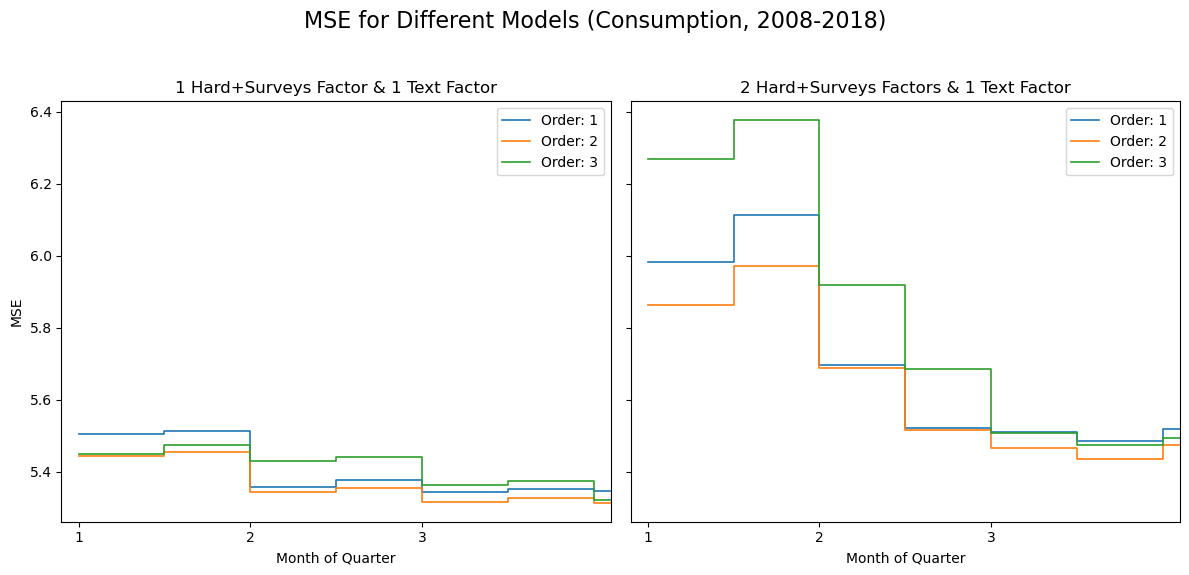

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


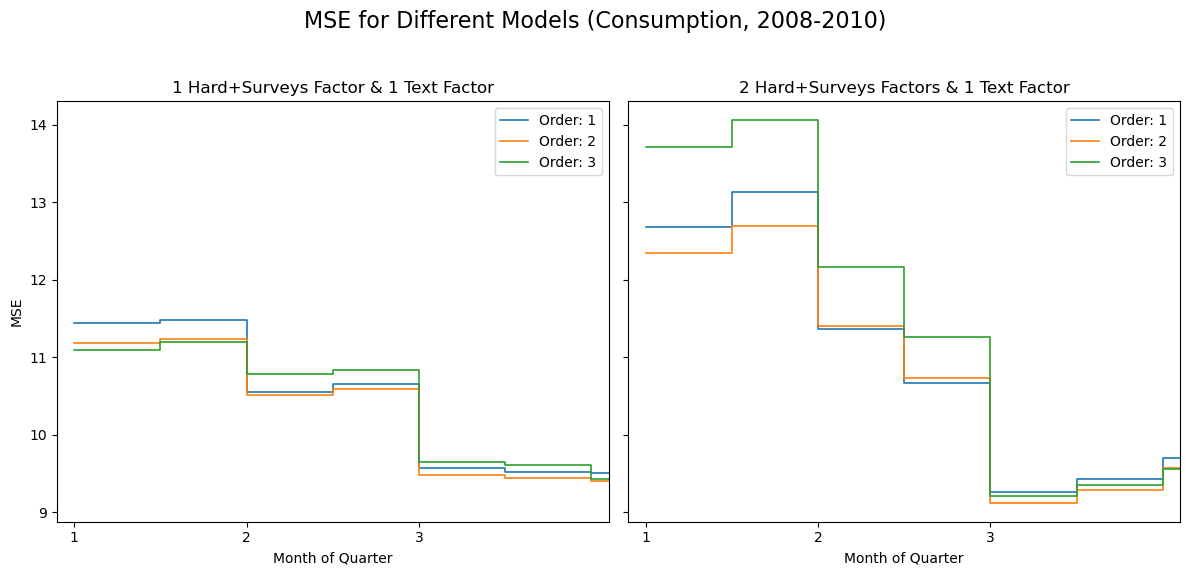

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


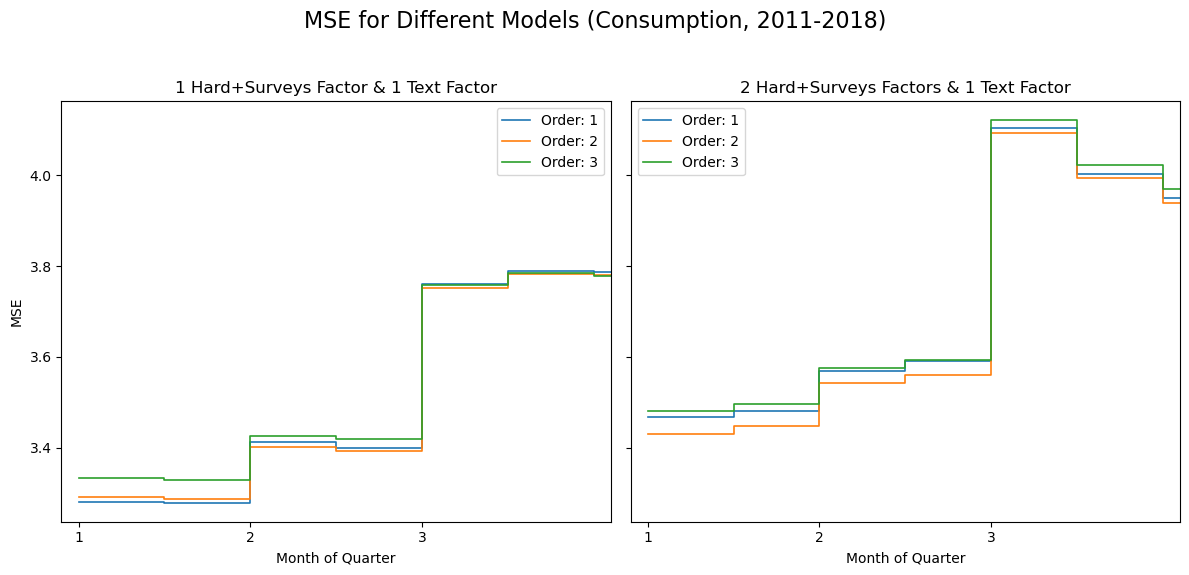

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


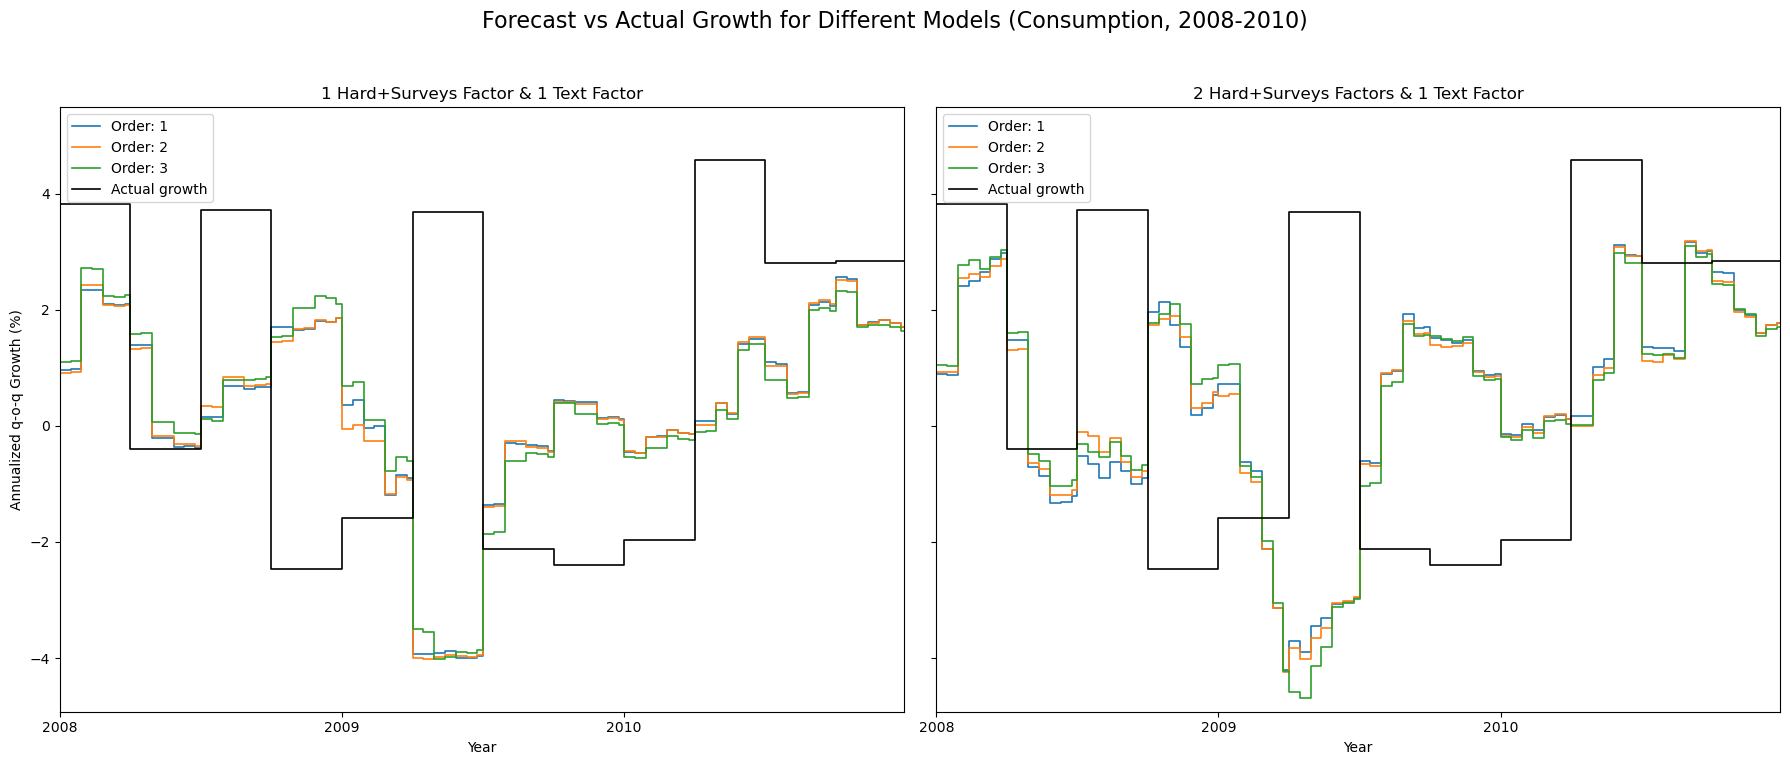

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


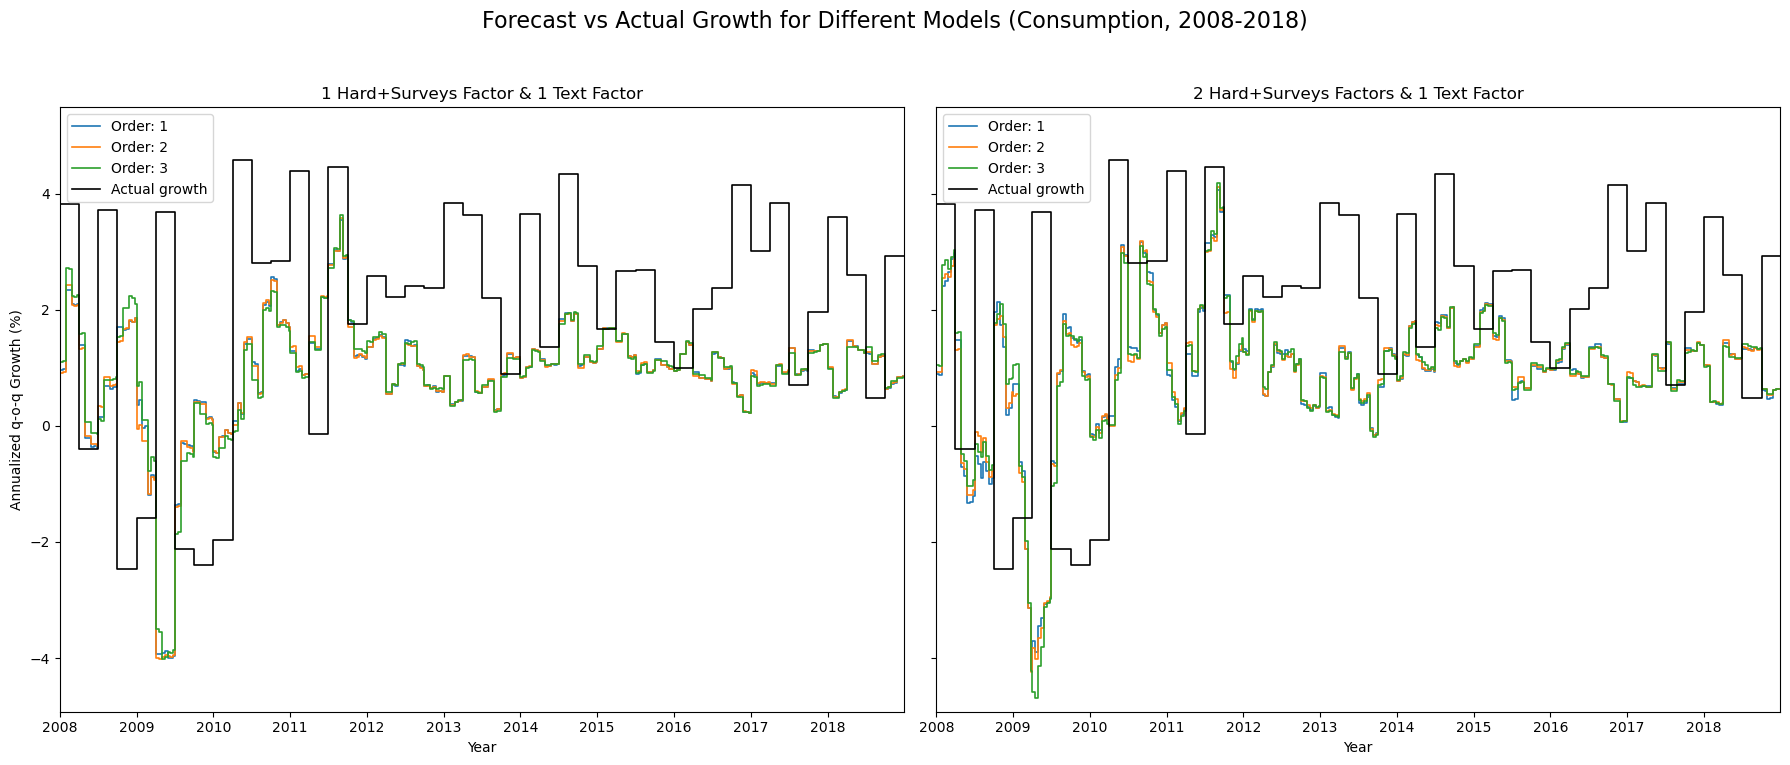

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


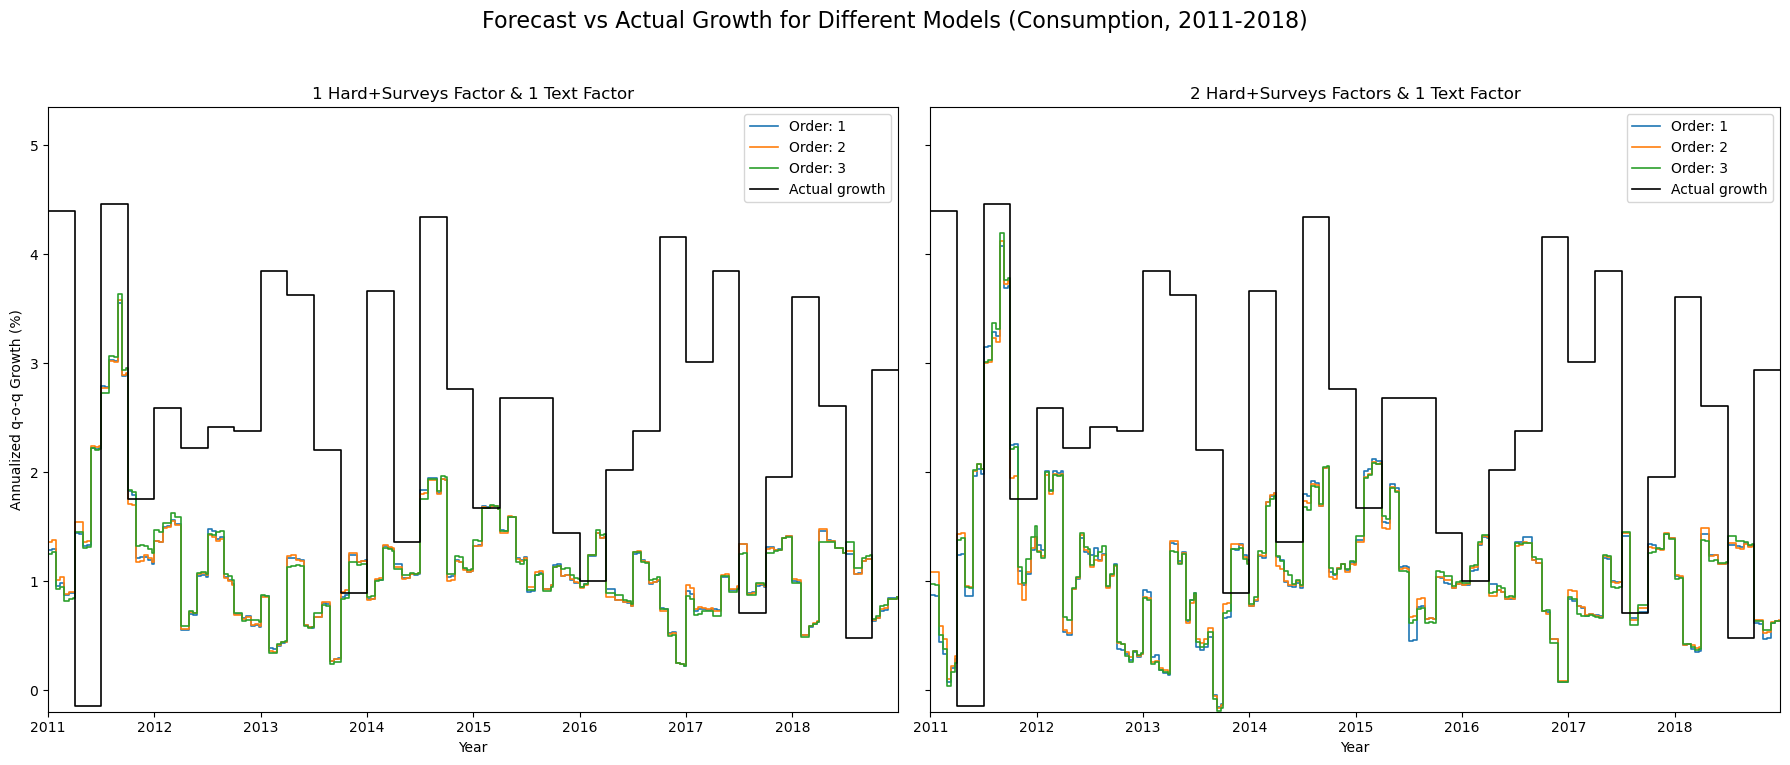

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()